In [33]:
from pathlib import Path
from vesper.models.serialization import create_test_dataset, load_test_dataset
from vesper.models.variants import *
from vesper.models.reads import ReadGroup, AlignedRead
from vesper.models.interval import GenomicInterval
from vesper.models.repeatmasker import RepeatMaskerResult
from vesper.processors.vcf import VCFProcessor
from vesper.processors.reads import ReadProcessor

from vesper.analysis.breakpoint import *
from vesper.analysis.kmer import *

import numpy as np
import pandas as pd

import re

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import font_manager
import seaborn as sns

# save stock defaults for reference
default_font_family = plt.rcParams['font.family']
default_fonts = plt.rcParams['font.sans-serif'] 

# set default font 
font_path = '/System/Library/Fonts/HelveticaNeue.ttc'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.sans-serif'] = prop.get_name()

In [ ]:
# only run with a new dataset to be saved
# with VCFProcessor(Path('/Users/stacy/sudmant/vesper/output/894.duplomap.annotated.refined.vcf.gz')) as vcf_proc, \
#     ReadProcessor(Path('/Users/stacy/sudmant/vesper/tests/files/hg38/894.duplomap.bam'), registry_dir=Path('/Users/stacy/sudmant/vesper/output/894.duplomap.annotated.refined.read_registry')) as read_proc:
specimens = ['5980', '898', '5619', '899', '895', '5621', 'ASD6058', 'TSC6830', 'TSC7237', 'N22T', 'RG6P', 'SY3L014', '0EL2', 'ASD6463', '0068', '894']

all_variants = []
for specimen in specimens:
    with VCFProcessor(Path(f'/Users/stacy/sudmant/vesper/output/qc_all/{specimen}/{specimen}.duplomap.qc_all.shared.annotated.refined.vcf.gz')) as vcf_proc, \
        ReadProcessor(Path(f'/Volumes/mnemosyne/spermSV/output/alignment/hg38/minimap2/duplomap/mapped/{specimen}/realigned.bam')) as read_proc:
        variants = list(vcf_proc.instantiate_variants())
        for variant in variants:
            support_reads, nonsupport_reads = read_proc.get_read_groups(variant.variant)
            variant.support_reads = support_reads
            variant.nonsupport_reads = nonsupport_reads
            variant._calculate_grouped_metrics()
            variant._calculate_confidence()
        specimen_variants = create_test_dataset(variants, Path(f"/Users/stacy/sudmant/vesper/notebooks/files/{specimen}_variants.pkl"), include_sequence=True)
        all_variants.extend(specimen_variants)
all_variants = create_test_dataset(all_variants, Path(f"/Users/stacy/sudmant/vesper/notebooks/files/all_variants.pkl"), include_sequence=True)

In [2]:
all_variants = load_test_dataset(Path("/Users/stacy/sudmant/vesper/notebooks/files/all_variants.pkl"))

In [3]:
BreakPointAnalyzer = BreakpointAnalyzer(reference_fasta = Path("/Users/stacy/sudmant/references/hg38_HGSVC/hg38.no_alt.fa"),
                                        context_size = 50,
                                        max_edit = 0)

microhomology_data = []
tsd_data = []
poly_a_tail_data = []
for variant in all_variants:
    breakpoint = BreakPointAnalyzer.analyze_breakpoint(variant)
    repeat_class = variant.repeatmasker_results[0].repeat_class
    repeat_name = variant.repeatmasker_results[0].repeat_name
    if breakpoint.microhomology[0]:
        _, microhomology_sequence, microhomology_length, microhomology_coords = breakpoint.microhomology
        microhomology_entry = {
            'variant_id': variant.variant.ID,
            'repeat_class': repeat_class,
            'repeat_name': repeat_name,
            'microhomology_sequence': microhomology_sequence,
            'microhomology_length': microhomology_length,
            'microhomology_coords': microhomology_coords
        }
        microhomology_data.append(microhomology_entry)
    if breakpoint.tsd[0]:
        _, tsd_edit_distance, left_tsd_sequence, right_tsd_sequence, tsd_length, tsd_coords = breakpoint.tsd
        
        tsd_entry = {
            'variant_id': variant.variant.ID,
            'repeat_class': repeat_class,
            'repeat_name': repeat_name,
            'tsd_edit_distance': tsd_edit_distance,
            'left_tsd_sequence': left_tsd_sequence,
            'right_tsd_sequence': right_tsd_sequence,
            'tsd_length': tsd_length,
            'tsd_coords': tsd_coords # remember these are relative to the insertion
        }
        tsd_data.append(tsd_entry)
    if breakpoint.poly_a_tail[0]:
        _, poly_a_tail_length, poly_a_tail_coords = breakpoint.poly_a_tail
        
        poly_a_tail_entry = {
            'variant_id': variant.variant.ID,
            'repeat_class': repeat_class,
            'repeat_name': repeat_name,
            'poly_a_tail_length': poly_a_tail_length,
            'poly_a_tail_coords': poly_a_tail_coords # remember these are relative to the insertion
        }
        poly_a_tail_data.append(poly_a_tail_entry)

microhomology_df = pd.DataFrame(microhomology_data) # kind of broken rn leave for later
tsd_df = pd.DataFrame(tsd_data)
poly_a_tail_df = pd.DataFrame(poly_a_tail_data)

In [4]:
def reverse_complement(sequence):
    """Return the reverse complement of a DNA sequence."""
    complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C',
                 'a': 't', 't': 'a', 'c': 'g', 'g': 'c'}
    return ''.join(complement.get(base, base) for base in sequence[::-1])

def extract_alu_info(variant):
    """Extract Alu-related information from a variant."""
    rm_result = variant.repeatmasker_results[0]
    ins_seq = variant.variant.alt
    
    if rm_result.strand == 'C':
        ins_seq = reverse_complement(ins_seq)
        
    return {
        'repeat_name': rm_result.repeat_name,
        'ins_seq': ins_seq,
        'strand': rm_result.strand,
        'query_start': rm_result.query_start,
        'query_end': rm_result.query_end,
        'repeat_start': rm_result.repeat_start,
        'repeat_end': rm_result.repeat_end,
        'repeat_remaining': rm_result.repeat_left
    }

def create_alu_context_entry(breakpoint, alu_info):
    """Create a dictionary entry for Alu context information."""
    ins_seq = alu_info['ins_seq']
    query_start = alu_info['query_start']
    query_end = alu_info['query_end']
    
    return {
        'ins_name': alu_info['repeat_name'],
        'original_strand': alu_info['strand'],
        'left_context': breakpoint.left_context,
        'right_context': breakpoint.right_context,
        'poly_a_tail_length': breakpoint.poly_a_tail[1],
        'poly_a_tail_start':  breakpoint.poly_a_tail[2][0],
        'poly_a_tail_end':  breakpoint.poly_a_tail[2][1],
        'left_tsd_seq': breakpoint.tsd[2],
        'right_tsd_seq': breakpoint.tsd[3],
        'tsd_edit_distance': breakpoint.tsd[1],
        'tsd_length': breakpoint.tsd[4],
        'left_tsd_start': breakpoint.tsd[5][0],
        'left_tsd_end': breakpoint.tsd[5][0] + breakpoint.tsd[4], 
        'right_tsd_start': len(ins_seq) + breakpoint.tsd[5][1], # adjust relative to the insertion seq
        'right_tsd_end': len(ins_seq) + breakpoint.tsd[5][1] + breakpoint.tsd[4], # adjust relative to the insertion seq
        'ins_seq': ins_seq,
        'ins_seq_length': len(ins_seq),
        'ins_query_start': query_start,
        'ins_query_end': query_end,
        'ins_pre_query': ins_seq[:query_start],
        'ins_match_seq': ins_seq[query_start:query_end],
        'ins_match_length': query_end - query_start,
        'ins_repeat_start': alu_info['repeat_start'],
        'ins_repeat_end': alu_info['repeat_end'],
        'ins_repeat_remaining': alu_info['repeat_remaining']
    }

alu_contexts = []
for variant in all_variants:
    if variant.repeatmasker_results[0].repeat_class == 'SINE/Alu':
        alu_info = extract_alu_info(variant)
        breakpoint = BreakPointAnalyzer.analyze_breakpoint(variant)
        context_entry = create_alu_context_entry(breakpoint, alu_info)
        alu_contexts.append(context_entry)

alu_contexts_df = pd.DataFrame(alu_contexts)


In [5]:
test = alu_contexts_df[['left_context', 'right_context', 'ins_seq','original_strand']].copy()
test['ins_seq'] = test['ins_seq'].str[:10]
test['left_context'] = test['left_context'].str[-20:] + test['ins_seq'].str[:5]
test['right_context'] = test['right_context'].str[:20]
# test['ins_seq'] = test.apply(lambda row: reverse_complement(row['ins_seq']) if row['original_strand'] == 'C' else row['ins_seq'], axis=1)
test['preceding_context'] = test.apply(lambda row: reverse_complement(row['left_context']) if row['original_strand'] == '+' else row['right_context'], axis=1)

# # Find first TT or tt and next 4 chars in left_context
# def get_tt_motif(context):
#     tt_idx = context.upper().find('TT')
#     if tt_idx != -1:
#         index = min(tt_idx + 6, len(context))
#         return context[tt_idx:index]
#     return None

# test['motif'] = test['left_context'].apply(get_tt_motif).str.upper()
# test.sort_values('motif', ascending=False)

# # Write left contexts to FASTA file
# with open('contexts.fasta', 'w') as f:
#     for idx, row in test.iterrows():
#         # Write header with sequence number 
#         f.write(f'>sequence_{idx}\n')
#         # Write sequence, ensuring one line per sequence
#         f.write(f'{row["preceding_context"]}\n')

In [6]:
alu_contexts_df.columns

Index(['ins_name', 'original_strand', 'left_context', 'right_context',
       'poly_a_tail_length', 'poly_a_tail_start', 'poly_a_tail_end',
       'left_tsd_seq', 'right_tsd_seq', 'tsd_edit_distance', 'tsd_length',
       'left_tsd_start', 'left_tsd_end', 'right_tsd_start', 'right_tsd_end',
       'ins_seq', 'ins_seq_length', 'ins_query_start', 'ins_query_end',
       'ins_pre_query', 'ins_match_seq', 'ins_match_length',
       'ins_repeat_start', 'ins_repeat_end', 'ins_repeat_remaining'],
      dtype='object')

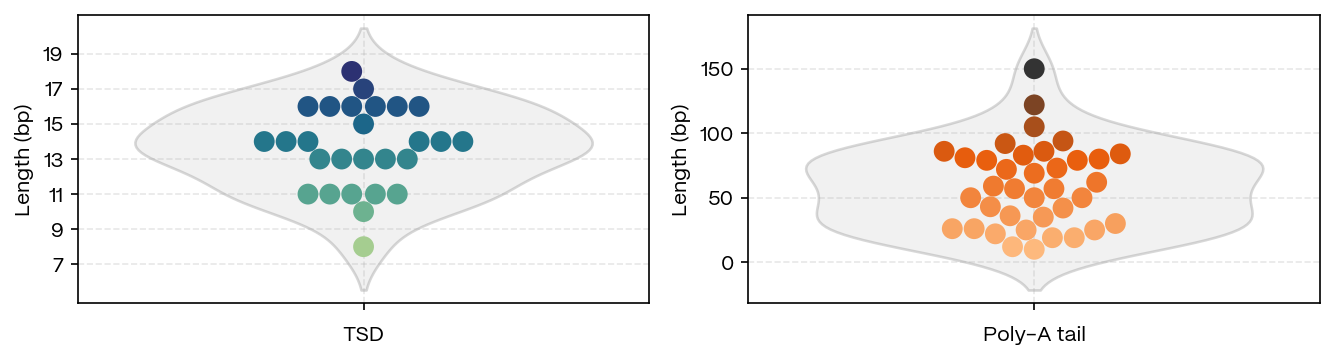

In [77]:
alu_tsd = tsd_df[tsd_df['repeat_class'] == 'SINE/Alu']
fig, axes = plt.subplots(1,2, figsize=(9, 2.5), dpi = 150) # Adjust figsize as needed

# left plot - TSD length distribution  - #AABBDF
sns.violinplot(ax=axes[0], data=alu_tsd, y='tsd_length', color = 'lightgray', alpha = 0.3, inner = None)
sns.swarmplot(ax=axes[0], data=alu_tsd, y='tsd_length', size = 10, hue='tsd_length', palette='crest', legend = False)
# axes[0].set_title('TSD Length Distribution')
axes[0].set_ylabel('Length (bp)')
axes[0].set_xlabel('TSD')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, linestyle='--', alpha=0.3)
axes[0].set_yticks(range(7, 20, 2))

# right plot - poly-A tail length distribution - '#F0B191'
sns.violinplot(ax=axes[1], data=alu_contexts_df, y='poly_a_tail_length', color = 'lightgray', alpha = 0.3, inner = None)
sns.swarmplot(ax=axes[1], data=alu_contexts_df, y='poly_a_tail_length', size = 10, hue='poly_a_tail_length', palette='Oranges_d', legend = False)
# axes[1].set_title('Poly-A Tail Length Distribution')
axes[1].set_ylabel('Length (bp)')
axes[1].set_xlabel('Poly-A tail')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, linestyle='--', alpha=0.3)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()
# Display the plot
plt.show()


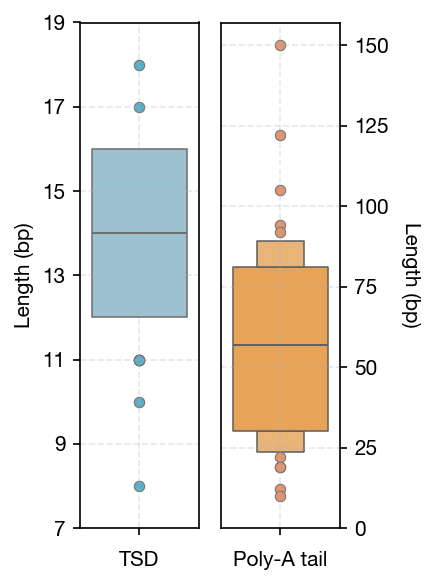

In [34]:
alu_tsd = tsd_df[tsd_df['repeat_class'] == 'SINE/Alu']
fig, axes = plt.subplots(1,2, figsize=(3, 4), dpi = 150) # Adjust figsize as needed

# left plot - TSD length distributio
# sns.violinplot(ax=axes[0], data=alu_tsd, y='tsd_length', color = 'lightgray', alpha = 0.3, inner = None)
sns.boxenplot(ax=axes[0], data=alu_tsd, y='tsd_length', color = '#93c6db',
              flier_kws=dict(facecolor="#5baec7", linewidth=.5))
# sns.swarmplot(ax=axes[0], data=alu_tsd, y='tsd_length', size = 7, linewidth = 0.5, edgecolor = 'gray', hue='tsd_length', palette='crest', legend = False)
# axes[0].set_title('TSD Length Distribution')
axes[0].set_ylabel('Length (bp)')
axes[0].set_xlabel('TSD')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, linestyle='--', alpha=0.3)
axes[0].set_yticks(range(7, 20, 2))

# right plot - poly-A tail length distribution
# sns.violinplot(ax=axes[1], data=alu_contexts_df, y='poly_a_tail_length', color = 'lightgray', alpha = 0.3, inner = None)
sns.boxenplot(ax=axes[1], data=alu_contexts_df, y='poly_a_tail_length', color = '#ffa640',
              flier_kws=dict(facecolor="#e0946e", linewidth=.5))
# sns.swarmplot(ax=axes[1], data=alu_contexts_df, y='poly_a_tail_length', size = 5, linewidth = 0.5, edgecolor = 'gray', hue='poly_a_tail_length', palette='Oranges_d', legend = False)
# axes[1].set_title('Poly-A Tail Length Distribution')
axes[1].yaxis.set_label_position('right')
axes[1].set_ylabel('Length (bp)', rotation=270, labelpad=15)
axes[1].set_xlabel('Poly-A tail')
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', right=True, left=False, labelright=True, labelleft=False)
axes[1].grid(True, linestyle='--', alpha=0.3)
axes[1].set_yticks(range(0, 151, 25))

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# transparent bg
fig.patch.set_alpha(0.0)
axes[0].patch.set_alpha(0.0)
axes[1].patch.set_alpha(0.0)

plt.savefig("/Users/stacy/Documents/Writing/spermSV/Figures/plots/tsd_poly_a_lengths.png", dpi = 300)
plt.savefig("/Users/stacy/Documents/Writing/spermSV/Figures/plots/tsd_poly_a_lengths.pdf")

/var/folders/d1/_d4s2fqs7_z4dhbkbh6b02xw0000gn/T/ipykernel_93424/1501940901.py:5: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.axvspan(xmin=280, xmax=310, alpha=0.4, color='lightgray',


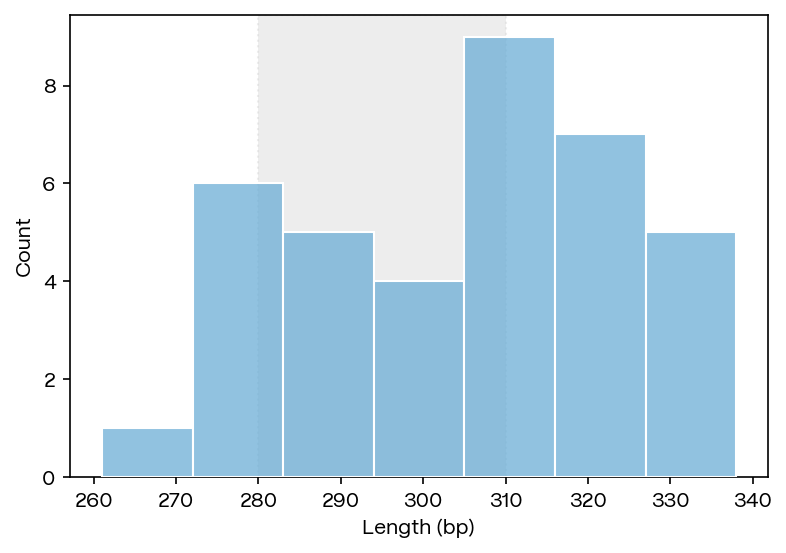

In [239]:
# Length of insertion sequence identified as Alu

plt.figure(figsize=(6, 4), dpi = 150)

plt.axvspan(xmin=280, xmax=310, alpha=0.4, color='lightgray',
            edgecolor = 'darkgray', linewidth = 1, linestyle = 'dotted', 
            zorder = 2)
sns.histplot(data=alu_contexts_df, x='ins_match_length',
             color = '#6caed6',
             edgecolor = 'white',
             zorder = 3)

# plt.axvline(x = 280, color = 'gray', linewidth = 1, linestyle = 'dotted')
# plt.axvline(x = 310, color = 'gray', linewidth = 1, linestyle = 'dotted')



# plt.title('Distribution of Insertion Match Lengths')
plt.xlabel('Length (bp)')
plt.ylabel('Count')
# plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout
plt.show()


/var/folders/d1/_d4s2fqs7_z4dhbkbh6b02xw0000gn/T/ipykernel_93424/3522454148.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(xmin=280, xmax=310, alpha=0.2, color='lightgray',


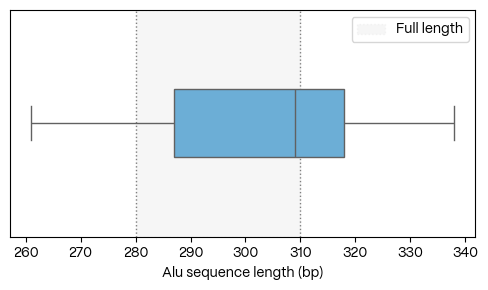

In [22]:
# Length of insertion sequence identified as Alu

fig, ax = plt.subplots(figsize=(5, 3))

sns.boxplot(ax = ax, data=alu_contexts_df, x='ins_match_length',
             color = '#6caed6',
             saturation=1,
             width=0.3,
             zorder = 3)  # Reduced width to make box appear shorter

ax.axvspan(xmin=280, xmax=310, alpha=0.2, color='lightgray',
            edgecolor = 'darkgray', linewidth = 1, linestyle = 'dotted', 
            zorder = 2, label = 'Full length')

plt.axvline(x = 280, color = 'gray', linewidth = 1, linestyle = 'dotted')
plt.axvline(x = 310, color = 'gray', linewidth = 1, linestyle = 'dotted')



# plt.title('Distribution of Insertion Match Lengths')
ax.set_yticks([])
ax.set_xlabel('Alu sequence length (bp)')
plt.legend()
plt.tight_layout()
plt.show()


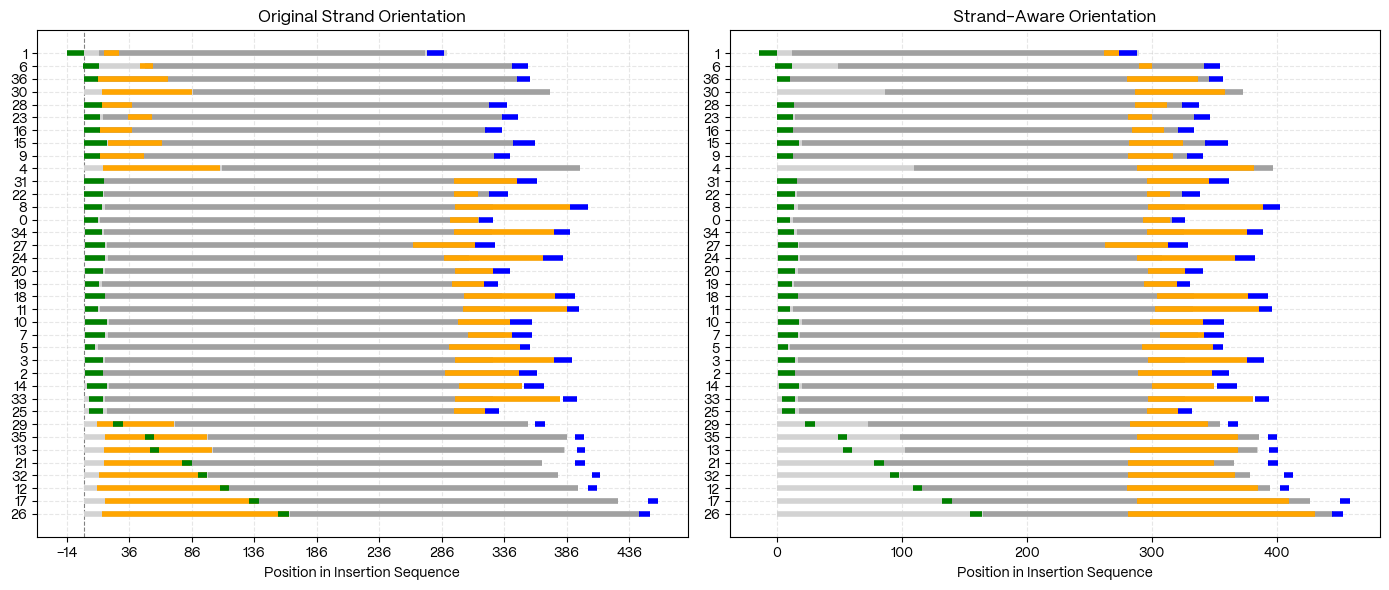

In [5]:
sorted_ins_coords = alu_contexts_df.sort_values(['left_tsd_start', 'original_strand'], ascending=[False, True])

# Create figure with two subplots to check that the strand-aware orientation is correct
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left subplot - original strand orientation
ax1.axvline(x = 0, color = 'grey', linestyle = '--', linewidth = 0.8)
for i, (_, row) in enumerate(sorted_ins_coords.iterrows()):
    ax1.hlines(y=i, xmin=0, xmax=row.ins_seq_length,
              linewidth=4, color='lightgray')
    ax1.hlines(y=i, xmin=row.ins_query_start, xmax=row.ins_query_end,
              linewidth=4, color='gray', alpha = 0.6)
    ax1.hlines(y=i, xmin=row.poly_a_tail_start, xmax=row.poly_a_tail_end,
              linewidth=4, color='orange')
    ax1.hlines(y=i, xmin=row.left_tsd_start, xmax=row.left_tsd_end,
              linewidth=4, color='green')
    ax1.hlines(y=i, xmin=row.right_tsd_start, xmax=row.right_tsd_end,
              linewidth=4, color='blue')

# Customize left subplot
ax1.set_xticks(np.arange(sorted_ins_coords.left_tsd_start.min(), sorted_ins_coords.right_tsd_end.max(), 50))
ax1.set_yticks(range(len(sorted_ins_coords)))
ax1.set_yticklabels([x for x in sorted_ins_coords.index])
ax1.set_xlabel('Position in Insertion Sequence')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_title('Original Strand Orientation')

# Right subplot - strand-aware orientation
for i, (_, row) in enumerate(sorted_ins_coords.iterrows()):
    ax2.hlines(y=i, xmin=0, xmax=row.ins_seq_length,
              linewidth=4, color='lightgray')
    
    query_start = row.ins_query_start
    query_end = row.ins_query_end
    if row.original_strand == 'C':
        # Inverse coordinates for C strand
        poly_a_start = row.ins_seq_length - row.poly_a_tail_end
        poly_a_end = row.ins_seq_length - row.poly_a_tail_start
    else:
        poly_a_start = row.poly_a_tail_start
        poly_a_end = row.poly_a_tail_end
        
    ax2.hlines(y=i, xmin=query_start, xmax=query_end,
              linewidth=4, color='gray', alpha = 0.6)
    ax2.hlines(y=i, xmin=poly_a_start, xmax=poly_a_end,
              linewidth=4, color='orange')
    ax2.hlines(y=i, xmin=row.left_tsd_start, xmax=row.left_tsd_end,
              linewidth=4, color='green')
    ax2.hlines(y=i, xmin=row.right_tsd_start, xmax=row.right_tsd_end,
              linewidth=4, color='blue')


# Customize right subplot
ax2.set_yticks(range(len(sorted_ins_coords)))
ax2.set_yticklabels([x for x in sorted_ins_coords.index])
ax2.set_xlabel('Position in Insertion Sequence')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_title('Strand-Aware Orientation')

plt.tight_layout()
plt.show()

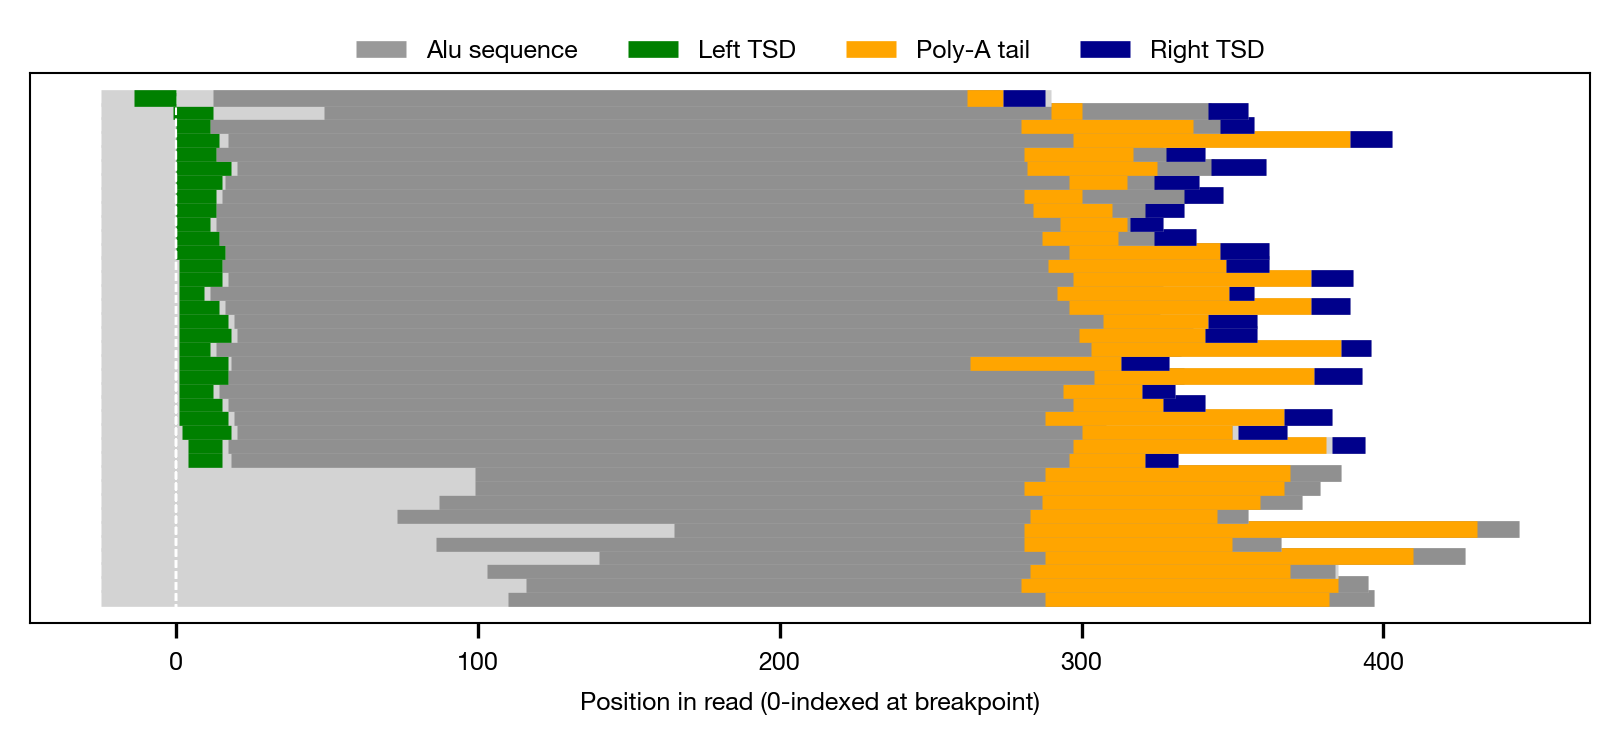

In [35]:
# Sort by tsd_seq being None last, then by left_tsd_start
def is_homopolymer(sequence, threshold=0.7):
    """
    Check if any single base makes up more than threshold% of the sequence.
    
    Args:
        sequence (str): DNA sequence to check
        threshold (float): Fraction threshold for homopolymer detection (default 0.7)
    Returns:
        bool: True if any base exceeds threshold fraction, False otherwise
    """
    if not sequence:
        return False
    
    seq_len = len(sequence)
    base_counts = {
        'A': sequence.upper().count('A') / seq_len,
        'C': sequence.upper().count('C') / seq_len, 
        'G': sequence.upper().count('G') / seq_len,
        'T': sequence.upper().count('T') / seq_len
    }

    for base, frac in base_counts.items():
        if frac >= threshold:
            stretch = base * int(frac * seq_len)
            if stretch in sequence:
                return True
    return False


sorted_ins_coords = alu_contexts_df.copy()
sorted_ins_coords.loc[(sorted_ins_coords['left_tsd_seq'].isna()) & 
                     (sorted_ins_coords['left_tsd_start'] == 0), 'left_tsd_start'] = None

sorted_ins_coords = sorted_ins_coords.sort_values(
    ['left_tsd_start'], 
    ascending=[False], 
    na_position='first'
)

fig, ax = plt.subplots(figsize=(5.5,2.6), dpi = 300)

# strand-aware orientation for viz
for i, (_, row) in enumerate(sorted_ins_coords.iterrows()):
    ax.hlines(y=i, xmin=-25, xmax=max(row.ins_seq_length, row.right_tsd_end),
              linewidth=4, color='lightgray')
    ax.axvline(x = 0, color = 'white', linestyle = 'dashed', linewidth = 0.5, alpha = 1)
    
    query_start = row.ins_query_start
    query_end = row.ins_query_end
    if row.original_strand == 'C':
        # Inverse coordinates for C strand
        poly_a_start = row.ins_seq_length - row.poly_a_tail_start
        poly_a_end = row.ins_seq_length - row.poly_a_tail_end
    else:
        poly_a_start = row.poly_a_tail_start
        poly_a_end = row.poly_a_tail_end
        
    ax.hlines(y=i, xmin=query_start, xmax=query_end,
              linewidth=4, color='gray', alpha = 0.8, label='Alu sequence' if i == 0 else "")
              
    # Check if left TSD is homopolymer
    if is_homopolymer(row.left_tsd_seq) and is_homopolymer(row.right_tsd_seq):
        ax.hlines(y=i, xmin=row.left_tsd_start, xmax=row.left_tsd_end,
                  linewidth=4, color='black', label='Homopolymer TSD' if i == 0 else "")
        ax.hlines(y=i, xmin=row.right_tsd_start, xmax=row.right_tsd_end,
                  linewidth=4, color='black')
    
    ax.hlines(y=i, xmin=row.left_tsd_start, xmax=row.left_tsd_end,
              linewidth=4, color='green', label='Left TSD' if i == 0 else "")
    ax.hlines(y=i, xmin=poly_a_start, xmax=poly_a_end,
              linewidth=4, color='orange', label='Poly-A tail' if i == 0 else "")
    ax.hlines(y=i, xmin=row.right_tsd_start, xmax=row.right_tsd_end,
              linewidth=4, color='darkblue', label='Right TSD' if i == 0 else "")
    
# # add spacing for reference line
# ax.hlines(y = -2, xmin = 0, xmax = 300, 
#           linewidth = 4, color = 'gray')
# ax.hlines(y = -2, xmin = -15, xmax = 0, 
#           linewidth = 4, color = 'green')
# ax.hlines(y = -2, xmin = 300, xmax = 360, 
#           linewidth = 4, color = 'orange')
# ax.hlines(y = -2, xmin = 360, xmax = 375, 
#           linewidth = 4, color = 'blue')

# Customize right subplot
# ax.set_yticks(range(len(sorted_ins_coords)))
# ax.set_yticklabels([x for x in sorted_ins_coords.index])
ax.set_yticks([])
# ax.xaxis.set_ticks_position('top')
# ax.xaxis.set_label_position('top')
ax.set_xlabel('Position in read (0-indexed at breakpoint)', size = 6)
ax.tick_params(axis='x', labelsize=6)
# ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(bbox_to_anchor=(0.5,1.1), ncol=4, loc='upper center', frameon=False, fontsize=6)

# Make figure border half width
for spine in ax.spines.values():
    spine.set_linewidth(0.5)

# transparent bg
fig.patch.set_alpha(0.0)
ax.patch.set_alpha(0.0)

plt.tight_layout()
plt.savefig("/Users/stacy/Documents/Writing/spermSV/Figures/plots/alu_profiles.png", dpi = 300)
plt.savefig("/Users/stacy/Documents/Writing/spermSV/Figures/plots/alu_profiles.pdf")

In [113]:
poly_a_stats = (sorted_ins_coords.groupby('ins_name')
 .agg({'poly_a_tail_length': ['min', 'mean', 'median', 'max', 'count']})
 ['poly_a_tail_length']
 .sort_values(by=['count', 'median'], ascending=[False, True])
)

poly_a_stats['mean'] = poly_a_stats['mean'].round(0)
poly_a_stats.reset_index()

,ins_name,min,mean,median,max,count
0,AluYa5,19,57.0,53.5,105,18
1,AluYb8,10,75.0,77.0,122,6
2,AluY,25,46.0,39.0,83,4
3,AluYk2,26,78.0,57.0,150,3
4,AluYg6,12,46.0,45.5,79,2
5,AluYi6,26,26.0,26.0,26,1
6,AluYb9,35,35.0,35.0,35,1
7,AluYe5,59,59.0,59.0,59,1
8,AluYh3,84,84.0,84.0,84,1


/var/folders/d1/_d4s2fqs7_z4dhbkbh6b02xw0000gn/T/ipykernel_1039/2888762416.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(labels)


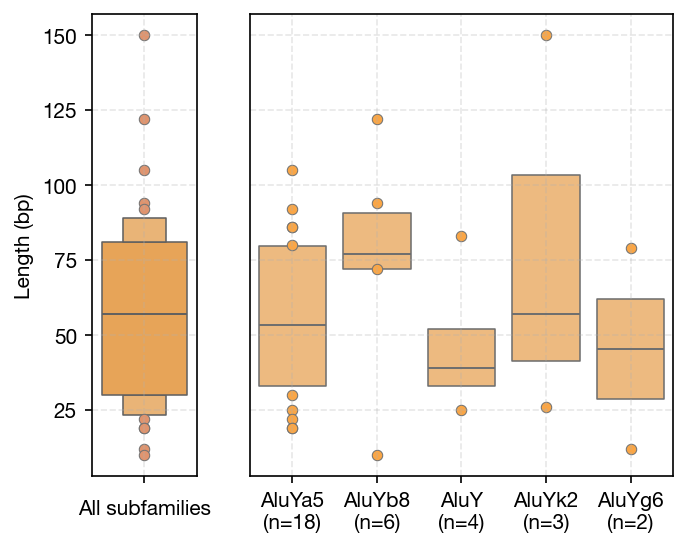

In [36]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(5,4), sharey=True, dpi = 150, gridspec_kw={'width_ratios': [1, 4]})
# left plot
sns.boxenplot(ax=ax[0], data=alu_contexts_df, y='poly_a_tail_length', color = '#ffa640',
              flier_kws=dict(facecolor="#e0946e", linewidth=.5))
ax[0].set_ylabel('Length (bp)')
ax[0].set_xlabel('All subfamilies')
ax[0].tick_params(axis='x', rotation=45)
ax[0].grid(True, linestyle='--', alpha=0.3)
ax[0].set_yticks(range(0, 151, 25))

# right plot
# Get sample sizes for each subfamily
sample_sizes = sorted_ins_coords['ins_name'].value_counts()
order = ['AluYa5', 'AluYb8', 'AluY', 'AluYk2', 'AluYg6']
labels = [f'{subfamily}\n(n={sample_sizes[subfamily]})' for subfamily in order]

sns.boxenplot(ax = ax[1], data=sorted_ins_coords, x='ins_name', y='poly_a_tail_length', color = '#ffbb6e', order=order,
              flier_kws=dict(facecolor="#faa646", linewidth=.5))
# sns.boxenplot(ax = ax[1], data=sorted_ins_coords, x='ins_name', y='poly_a_tail_length', color = '#ffbb6e', order=order)
ax[1].grid(True, alpha=0.3, linestyle='--')
ax[1].set_xticklabels(labels)
ax[1].set_xlabel('')
ax[1].tick_params(axis='y', length=0)  # Remove y tick marks

# transparent bg
fig.patch.set_alpha(0.0)
ax[0].patch.set_alpha(0.0)
ax[1].patch.set_alpha(0.0)

plt.savefig("/Users/stacy/Documents/Writing/spermSV/Figures/plots/poly_a_breakdown.png", dpi = 300)
plt.savefig("/Users/stacy/Documents/Writing/spermSV/Figures/plots/poly_a_breakdown.pdf")


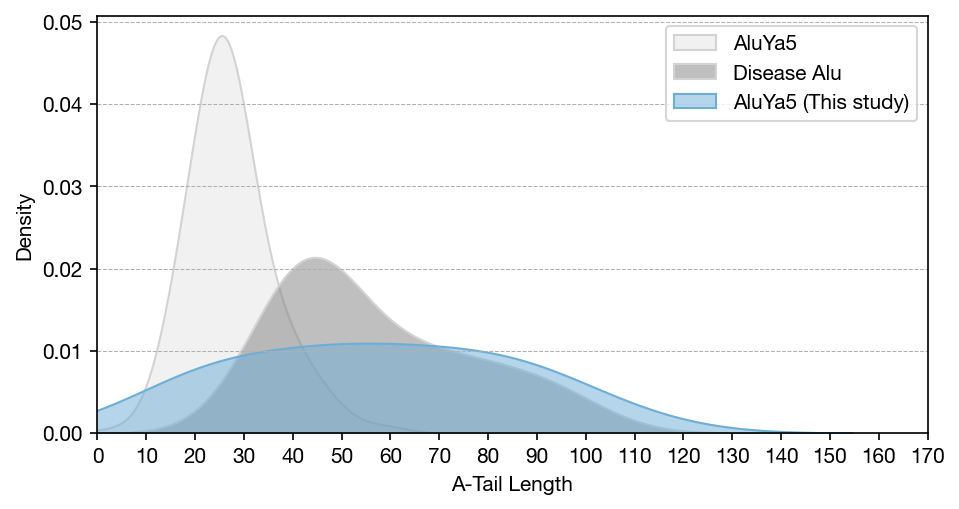

In [37]:
# Data from Roy-Engel et al. 2002, Genome Research
roy_engel_aluya5_counts = {
    3: 1,
    11: 2, 14: 2, 15: 5, 16: 7, 17: 6, 18: 5, 19: 5,
    20: 10, 21: 11, 22: 8, 23: 12, 24: 10, 25: 22, 26: 14, 27: 23, 28: 9, 29: 7,
    30: 9, 31: 13, 32: 0, 33: 7, 34: 6, 35: 5, 36: 3, 37: 3, 38: 2, 39: 5, 
    40: 0, 41: 3, 42: 0, 42: 3, 43: 3, 44: 3, 45: 0, 47: 3, 50: 3, 59: 2
}

roy_engel_alu_disease_counts = {
    39: 1, 40: 2, 41: 1, 42: 1, 43: 1, 44: 1, 45: 0, 46: 1, 48: 1, 49: 1, 
    62: 1, 64: 1, 68: 1, 80: 1, 78: 1, 91: 1, 96: 1
}

roy_engel_aluya5_counts = pd.DataFrame.from_dict(roy_engel_aluya5_counts, orient='index').reset_index()
roy_engel_aluya5_counts.columns = ['poly_a_tail_length', 'count']
roy_engel_aluya5_counts['percentage'] = roy_engel_aluya5_counts['count'] / roy_engel_aluya5_counts['count'].sum()

roy_engel_alu_disease_counts = pd.DataFrame.from_dict(roy_engel_alu_disease_counts, orient='index').reset_index()
roy_engel_alu_disease_counts.columns = ['poly_a_tail_length', 'count']
roy_engel_alu_disease_counts['percentage'] = roy_engel_alu_disease_counts['count'] / roy_engel_alu_disease_counts['count'].sum()

aluya5_counts = sorted_ins_coords[sorted_ins_coords['ins_name'] == 'AluYa5']['poly_a_tail_length'].value_counts().to_frame().reset_index()
aluya5_counts['percentage'] = aluya5_counts['count'] / aluya5_counts['count'].sum()


fig = plt.figure(figsize=(6.5,3.5), dpi =150)
# plt.bar(roy_engel_aluya5_counts['poly_a_tail_length'], roy_engel_aluya5_counts['percentage'], width=0.8, color='lightgray', alpha = 0.5, label = 'AluYa5')
# plt.bar(roy_engel_alu_disease_counts['poly_a_tail_length'], roy_engel_alu_disease_counts['percentage'], width=0.8, color='lightgray', label = 'Disease Alu')
# plt.bar(aluya5_counts['poly_a_tail_length'], aluya5_counts['percentage'], width=0.8, color='#6caed6', label = 'AluYa5 (This study)')

sns.kdeplot(data=roy_engel_aluya5_counts, x='poly_a_tail_length', weights='percentage', fill=True, alpha = 0.3, color='lightgray', label='AluYa5')
sns.kdeplot(data=roy_engel_alu_disease_counts, x='poly_a_tail_length', weights='percentage', fill=True, alpha = 0.5, color='gray', edgecolor='lightgray', label='Disease Alu')
sns.kdeplot(data=aluya5_counts, x='poly_a_tail_length', weights='percentage', fill=True, alpha = 0.5, color='#6caed6', label='AluYa5 (This study)')


plt.xlabel("A-Tail Length")
# plt.ylabel("Frequency")
plt.ylabel("Density")
plt.grid(axis='y', linestyle='--', linewidth=0.5)
# plt.yticks(range(0, 21, 5))
plt.xlim(0, 170)
plt.xticks(range(0, 171, 10))
plt.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))

# transparent bg
fig.patch.set_alpha(0.0)

plt.savefig("/Users/stacy/Documents/Writing/spermSV/Figures/plots/poly_a_comparison.png", dpi = 300)
plt.savefig("/Users/stacy/Documents/Writing/spermSV/Figures/plots/poly_a_comparison.pdf")